In [1]:
import pickle as pkl
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Reshape
from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
data_path = '/home/sjparsa/project/methyl_data/GPL13534/beta_values.pkl'
data_frame = pd.read_pickle(data_path)
data_frame = data_frame.dropna()
data_frame = data_frame.transpose()
data_frame = data_frame.sort_index()
#Remove samples that don't have a recorded age
condition1 = data_frame.index != '7512551037_R03C02'
data_frame = data_frame[condition1]
condition2 = data_frame.index != '7766148120_R01C02'
data_frame = data_frame[condition2]
condition3 = data_frame.index != '9379082134_R04C01'
data_frame = data_frame[condition3]
display(data_frame)
#data_frame.to_csv('/home/sjparsa/project/age_data.csv')

IlmnID,cg00000108,cg00000109,cg00000236,cg00000292,cg00000321,cg00000363,cg00000658,cg00000714,cg00000721,cg00000734,...,ch.X.1813402F,ch.X.42854404F,ch.X.42921571R,ch.X.652438R,ch.X.68408155R,ch.X.87262228F,ch.X.92554290F,ch.X.938089F,ch.X.94051109R,ch.X.97651759F
7512551003_R01C01,0.965663,0.903081,0.878515,0.927942,0.336811,0.415336,0.856233,0.223618,0.953013,0.054143,...,0.044522,0.048630,0.041736,0.038004,0.062345,0.054509,0.042281,0.051313,0.038188,0.038511
7512551003_R01C02,0.971825,0.921221,0.843145,0.912727,0.233886,0.429177,0.850460,0.275970,0.956237,0.048573,...,0.033172,0.037611,0.036861,0.050641,0.032720,0.028857,0.046654,0.030592,0.027858,0.024734
7512551003_R02C01,0.967112,0.900410,0.881665,0.880979,0.300044,0.379536,0.830604,0.181489,0.945938,0.067694,...,0.033783,0.027450,0.031455,0.032232,0.030380,0.037908,0.044335,0.033915,0.032560,0.027871
7512551003_R02C02,0.964718,0.926568,0.872259,0.892606,0.278256,0.522999,0.831515,0.209469,0.949638,0.070087,...,0.031665,0.035550,0.027510,0.045380,0.027447,0.029421,0.024981,0.026285,0.027210,0.025725
7512551003_R03C01,0.970456,0.912688,0.844773,0.930858,0.278010,0.377733,0.835596,0.217374,0.951724,0.057199,...,0.037178,0.035773,0.024699,0.034030,0.031385,0.027373,0.029468,0.025773,0.025337,0.022851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9379082152_R04C02,0.971912,0.928515,0.813597,0.855637,0.272963,0.357975,0.822172,0.203579,0.964141,0.063976,...,0.031922,0.035221,0.029148,0.031486,0.031175,0.029559,0.040696,0.025981,0.029799,0.025892
9379082152_R05C01,0.962097,0.901766,0.840813,0.904162,0.300971,0.390735,0.862114,0.220633,0.948753,0.054300,...,0.030146,0.043266,0.033678,0.037046,0.039138,0.027109,0.047430,0.028923,0.032641,0.030085
9379082152_R05C02,0.950814,0.907934,0.869966,0.880501,0.260739,0.355777,0.859096,0.210223,0.952619,0.058867,...,0.039780,0.043194,0.049433,0.037497,0.062331,0.039499,0.039922,0.041514,0.043584,0.037978
9379082152_R06C01,0.970963,0.893647,0.876681,0.862322,0.312825,0.363495,0.837038,0.184124,0.957426,0.040216,...,0.028708,0.044336,0.038981,0.033864,0.035282,0.029390,0.033017,0.025322,0.029855,0.024152


In [3]:
labels = pd.read_csv('/home/sjparsa/project/GSE87571_GPL13534_samplesheet.csv')
labels = labels.sort_values(by='Sample_ID')
labels = labels.dropna()
display(labels)

,GSM_ID,Sample_Name,Sentrix_ID,Sentrix_Position,gender,age,tissue,disease state,description,Sample_ID
714,GSM2334618,X715 genomic DNA from whole blood,7512551003,R01C01,Male,59.0,whole blood,normal,normal whole blood,7512551003_R01C01
707,GSM2334611,X708 genomic DNA from whole blood,7512551003,R01C02,Female,15.0,whole blood,normal,normal whole blood,7512551003_R01C02
716,GSM2334620,X717 genomic DNA from whole blood,7512551003,R02C01,Female,86.0,whole blood,normal,normal whole blood,7512551003_R02C01
710,GSM2334614,X711 genomic DNA from whole blood,7512551003,R02C02,Female,73.0,whole blood,normal,normal whole blood,7512551003_R02C02
724,GSM2334628,X725 genomic DNA from whole blood,7512551003,R03C01,Female,74.0,whole blood,normal,normal whole blood,7512551003_R03C01
...,...,...,...,...,...,...,...,...,...,...
411,GSM2334315,X412 genomic DNA from whole blood,9379082152,R04C02,Female,44.0,whole blood,normal,normal whole blood,9379082152_R04C02
449,GSM2334353,X450 genomic DNA from whole blood,9379082152,R05C01,Female,50.0,whole blood,normal,normal whole blood,9379082152_R05C01
396,GSM2334300,X397 genomic DNA from whole blood,9379082152,R05C02,Male,36.0,whole blood,normal,normal whole blood,9379082152_R05C02
451,GSM2334355,X452 genomic DNA from whole blood,9379082152,R06C01,Female,59.0,whole blood,normal,normal whole blood,9379082152_R06C01


In [4]:
ages = np.array(labels['age'][:])
#age_labels = age_labels / 100
min_age = np.min(ages)
max_age = np.max(ages)
age_labels = ages/max_age
print(age_labels)
#print(age_labels)

[0.62765957 0.15957447 0.91489362 0.77659574 0.78723404 0.81914894
 0.55319149 0.59574468 0.40425532 0.65957447 0.18085106 0.72340426
 0.4787234  0.56382979 0.65957447 0.40425532 0.54255319 0.46808511
 0.18085106 0.4787234  0.42553191 0.53191489 0.5        0.5
 0.41489362 0.67021277 0.30851064 0.36170213 0.4787234  0.54255319
 0.54255319 0.35106383 0.22340426 0.36170213 0.22340426 0.20212766
 0.5        0.15957447 0.43617021 1.         0.15957447 0.35106383
 0.59574468 0.36170213 0.85106383 0.39361702 0.5        0.21276596
 0.59574468 0.35106383 0.5212766  0.4893617  0.26595745 0.44680851
 0.57446809 0.34042553 0.5106383  0.20212766 0.28723404 0.30851064
 0.42553191 0.46808511 0.15957447 0.40425532 0.35106383 0.64893617
 0.18085106 0.88297872 0.25531915 0.17021277 0.41489362 0.42553191
 0.55319149 0.72340426 0.19148936 0.41489362 0.38297872 0.22340426
 0.5        0.21276596 0.54255319 0.17021277 0.21276596 0.22340426
 0.46808511 0.30851064 0.20212766 0.17021277 0.32978723 0.28723404
 0

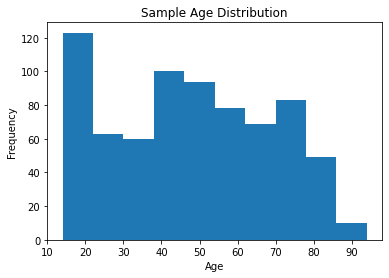

In [5]:
import matplotlib.pyplot as plt
plt.hist(age_labels*max_age)
plt.title('Sample Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

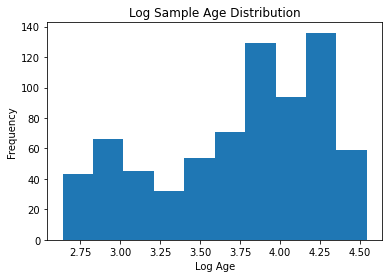

In [6]:
plt.hist(np.log(ages))
plt.title('Log Sample Age Distribution')
plt.xlabel('Log Age')
plt.ylabel('Frequency')
plt.show()

In [6]:
#split into train, validation, test data
train_val_x, test_x, train_val_y, test_y = train_test_split(data_frame, age_labels, test_size=0.1, random_state=42)

In [7]:
#Random forest without PCA
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2, random_state=42)

In [9]:
regr2 = RandomForestRegressor()
regr2.fit(train_x,train_y*max_age)

RandomForestRegressor()

In [10]:
val_preds = regr2.predict(val_x)

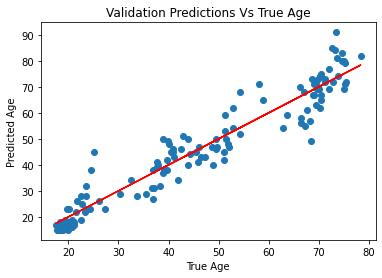

In [11]:
plt.scatter(val_preds, val_y*max_age)
plt.plot(val_preds, val_preds, color = 'red', label = 'x=y')
plt.plot()
plt.title('Validation Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [12]:
regr2.score(val_x, val_y*max_age)

0.9180263600479364

In [13]:
explained_variance_score(val_y*max_age, val_preds)

0.9180409730602195

In [14]:
mean_absolute_error(val_y*max_age, val_preds)

4.614166666666667

In [15]:
mean_squared_error(val_y*max_age, val_preds)

36.24243560606061

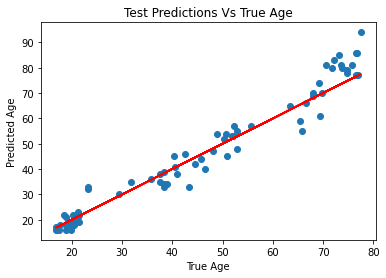

In [16]:
test_preds = regr2.predict(test_x)
plt.scatter(test_preds, test_y*max_age)
plt.plot(test_preds, test_preds, color = 'red', label = 'x=y')
plt.plot()
plt.title('Test Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [17]:
print(regr2.score(test_x, test_y*max_age))
print(explained_variance_score(test_y*max_age, test_preds))
print(mean_absolute_error(test_y*max_age, test_preds))
print(mean_squared_error(test_y*max_age, test_preds))

0.9500430030892577
0.9518902344431313
3.802876712328768
26.87410821917809


In [ ]:
import shap
explainer = shap.TreeExplainer(loaded_rf, train_x[:100])
shap_values = explainer.shap_values(test_x[:10])
# init the JS visualization code
shap.initjs()
#shap.force_plot(explainer.expected_value[, shap_values[0][0], test_x[0])

shap.summary_plot(shap_values, test_x[:10])


#shap.initjs()
#shap_values = explainer.shap_values(PredData, approximate=True)

In [18]:
joblib.dump(regr2, "my_random_forest.joblib")

['my_random_forest.joblib']

In [8]:
loaded_rf = joblib.load("my_random_forest.joblib")

In [15]:
model = tf.keras.models.Sequential()
model.add(Dense(64,activation='elu'))
#model.add(Dropout(0.3))
model.add(Dense(128,activation='elu'))
#model.add(Dropout(0.3))
model.add(Dense(256,activation='elu'))
#model.add(Dropout(0.3))
model.add(Dense(128,activation='elu'))
#model.add(Dropout(0.3))
model.add(Dense(64,activation='elu'))
#model.add(Dropout(0.3))
model.add(Dense(1,activation='elu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50)

Epoch 1/50
17/17 [==============================] - 3s 118ms/step - loss: 3.8767 - mean_absolute_error: 1.6952 - val_loss: 2.2759 - val_mean_absolute_error: 1.4919
Epoch 2/50
17/17 [==============================] - 2s 105ms/step - loss: 2.3237 - mean_absolute_error: 1.5086 - val_loss: 2.2759 - val_mean_absolute_error: 1.4919
Epoch 3/50
17/17 [==============================] - 2s 104ms/step - loss: 2.3237 - mean_absolute_error: 1.5086 - val_loss: 2.2759 - val_mean_absolute_error: 1.4919
Epoch 4/50
17/17 [==============================] - 2s 104ms/step - loss: 2.3237 - mean_absolute_error: 1.5086 - val_loss: 2.2759 - val_mean_absolute_error: 1.4919
Epoch 5/50
17/17 [==============================] - 2s 103ms/step - loss: 2.3237 - mean_absolute_error: 1.5086 - val_loss: 2.2759 - val_mean_absolute_error: 1.4919
Epoch 6/50
17/17 [==============================] - 2s 103ms/step - loss: 2.3237 - mean_absolute_error: 1.5086 - val_loss: 2.2759 - val_mean_absolute_error: 1.4919
Epoch 7/50
17/17

In [ ]:
print("hi")

In [ ]:
#end random forest without pca

In [8]:
from sklearn.preprocessing import StandardScaler
#normalize the train_val samples and fit pca to the data
normalized = StandardScaler().fit_transform(train_val_x)
pca = PCA(n_components = 0.9)
fitted = pca.fit_transform(normalized)
print(f"The total variance explained by the PCA is: {sum(pca.explained_variance_ratio_)}")
print(f"The number of features is: {len(pca.explained_variance_ratio_)}")

The total variance explained by the PCA is: 0.900550956488587
The number of features is: 445


In [9]:
#split train_val data into train and validation
renormalized = StandardScaler().fit_transform(fitted)
print(renormalized.shape)
train_x, val_x, train_y, val_y = train_test_split(renormalized, train_val_y, test_size=0.2, random_state=42)
#fit the test data with the pca and normalize
test_normalized = StandardScaler().fit_transform(test_x)
test_x = pca.transform(test_normalized)
test_x = StandardScaler().fit_transform(test_x)

print("Training data shape: " + str(train_x.shape))
print("Training data label shape: " + str(train_y.shape))
print("Validation data shape: " + str(val_x.shape))
print("Training data label shape: " + str(val_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test data label shape: " + str(test_y.shape))

(656, 445)
Training data shape: (524, 445)
Training data label shape: (524,)
Validation data shape: (132, 445)
Training data label shape: (132,)
Test data shape: (73, 445)
Test data label shape: (73,)


In [10]:
display(pd.DataFrame(train_x))

,0,1,2,3,4,5,6,7,8,9,...,435,436,437,438,439,440,441,442,443,444
0,-2.093535,0.042276,0.045723,0.475280,0.061801,0.657094,-1.525329,-0.222126,0.798936,1.183147,...,-0.358919,-0.916780,0.893198,0.060183,1.361954,-0.084647,-0.859915,-1.020705,-0.181127,0.220155
1,-0.989919,-0.467857,0.529548,-1.016478,0.306258,0.110069,0.926344,-0.556395,0.184794,-0.194163,...,0.217525,-0.443207,-0.464473,0.021696,0.477557,-0.600441,-0.952602,0.008367,-0.139387,0.412730
2,1.007734,0.617766,0.324272,-1.771832,-0.797731,1.468716,1.166168,-0.338390,0.516891,-1.259848,...,0.008422,0.007120,-0.026335,0.034192,0.196799,-0.155294,-0.151317,-0.143975,-0.037719,0.143820
3,-1.758013,-0.743645,1.528642,-0.032216,-0.521887,1.319396,1.363762,-0.015160,0.241006,-0.200569,...,0.034165,-0.422638,0.065298,-3.674447,0.196942,3.066707,1.683862,-0.950734,0.548373,2.400403
4,0.650804,-1.803120,-1.229142,0.629764,0.964208,1.091979,0.967174,-0.666617,-0.910502,-0.207994,...,0.420852,-0.875119,0.113957,-0.311774,0.077407,-0.112379,-0.232234,0.277576,0.594679,0.425798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,1.273594,0.880877,0.254915,-0.763393,1.746345,-0.062047,-1.578655,-0.065804,0.378901,-0.978572,...,-0.101466,0.924412,-0.133184,0.643944,0.125468,0.047907,-0.536168,-0.300719,-0.375110,-0.088734
520,-0.341640,-0.253890,-0.169725,0.363978,0.986257,-1.795056,0.852965,-0.486946,-0.485659,-0.792581,...,-0.521222,0.181624,-0.621904,-0.887869,-0.135762,0.349313,0.248401,0.105092,0.586894,-0.231739
521,1.489661,-0.619631,-1.029957,0.387140,-0.431975,0.999359,-1.242221,0.152977,0.120532,0.397309,...,-0.160393,-0.049446,0.264771,0.236196,-0.055567,0.039202,-0.249182,0.053766,0.128713,-0.166394
522,-0.149299,-1.017545,-0.567956,-0.637402,-0.576368,-1.251323,0.810028,-0.529941,-0.047367,-0.072002,...,0.662022,0.791282,1.871832,0.901722,-1.928943,-2.417260,2.137235,1.233359,-0.855674,0.007988


In [11]:
regr = RandomForestRegressor()
regr.fit(train_x,train_y*max_age)

RandomForestRegressor()

In [12]:
val_preds = regr.predict(val_x)

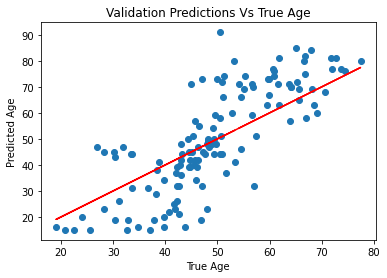

In [13]:
plt.scatter(val_preds, val_y*max_age)
plt.plot(val_preds, val_preds, color = 'red', label = 'x=y')
plt.plot()
plt.title('Validation Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [14]:
regr.score(val_x, val_y*max_age)

0.6039088651190627

In [15]:
explained_variance_score(val_y*max_age, val_preds)

0.6052255183429234

In [16]:
mean_absolute_error(val_y*max_age, val_preds)

10.037424242424242

In [17]:
mean_squared_error(val_y*max_age, val_preds)

161.58015454545455

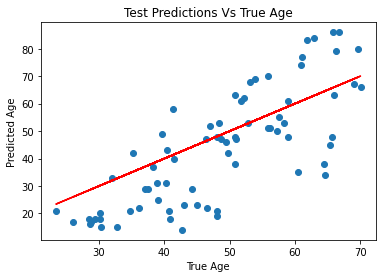

In [18]:
test_preds = regr.predict(test_x)
plt.scatter(test_preds, test_y*max_age)
plt.plot(test_preds, test_preds, color = 'red', label = 'x=y')
plt.plot()
plt.title('Test Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [20]:
print(regr.score(test_x, test_y*max_age))
print(explained_variance_score(test_y*max_age, test_preds))
print(mean_absolute_error(test_y*max_age, test_preds))
print(mean_squared_error(test_y*max_age, test_preds))

0.5264411388340487
0.5774412295187537
11.738082191780821
201.47321369863013


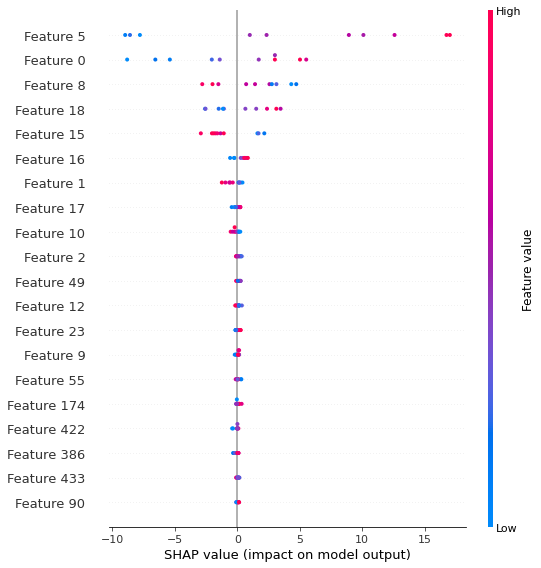

In [27]:
import shap
explainer = shap.TreeExplainer(regr, train_x[:100])
shap_values = explainer.shap_values(test_x[:10])
# init the JS visualization code
shap.initjs()
#shap.force_plot(explainer.expected_value[, shap_values[0][0], test_x[0])

shap.summary_plot(shap_values, test_x[:10])


#shap.initjs()
#shap_values = explainer.shap_values(PredData, approximate=True)

In [20]:
BATCH_SIZE_TRAIN=256
BATCH_SIZE_VAL=128
train_dset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(BATCH_SIZE_TRAIN)
val_dset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(BATCH_SIZE_VAL)

2021-12-05 21:40:53.238275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 21:40:53.256787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-12-05 21:40:53.258402: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registeri

In [ ]:
import joblib
joblib.dump(rf, "./random_forest.joblib")
loaded_rf = joblib.load("./random_forest.joblib")

In [26]:
print(val_y)

[0.91489362 0.80851064 0.59574468 0.4787234  0.36170213 0.67021277
 0.79787234 0.18085106 0.38297872 0.32978723 0.79787234 0.18085106
 0.31914894 0.42553191 0.79787234 0.65957447 0.81914894 0.4893617
 0.60638298 0.88297872 0.65957447 0.4787234  0.35106383 0.74468085
 0.32978723 0.32978723 0.73404255 0.75531915 0.5212766  0.19148936
 0.62765957 0.38297872 0.44680851 0.5        0.15957447 0.86170213
 0.23404255 0.84042553 0.17021277 0.73404255 0.57446809 0.19148936
 0.18085106 0.56382979 0.17021277 0.46808511 0.34042553 0.60638298
 0.5106383  0.62765957 0.23404255 0.80851064 0.18085106 0.18085106
 0.62765957 0.86170213 0.23404255 0.22340426 0.73404255 0.65957447
 0.63829787 0.18085106 0.72340426 0.65957447 0.15957447 0.24468085
 0.4787234  0.70212766 0.81914894 0.63829787 0.24468085 0.71276596
 0.37234043 0.41489362 0.74468085 0.5212766  0.18085106 0.44680851
 0.23404255 0.38297872 0.73404255 0.20212766 0.58510638 0.46808511
 0.54255319 0.78723404 0.76595745 0.41489362 0.85106383 0.27659

In [24]:
def create_eval_model(layer_1_neurons, layer_2_neurons, layer_3_neurons, layer_4_neurons, layer_5_neurons):
    model = tf.keras.models.Sequential()
    model.add(Dense(layer_1_neurons, activation = 'elu'))
    model.add(Dropout(0.3))
    model.add(Dense(layer_2_neurons, activation = 'elu'))
    model.add(Dropout(0.3))
    model.add(Dense(layer_3_neurons, activation = 'elu'))
    model.add(Dropout(0.3))
    model.add(Dense(layer_4_neurons, activation = 'elu'))
    model.add(Dropout(0.3))
    model.add(Dense(layer_5_neurons, activation = 'elu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.fit(train_dset, epochs=50, verbose=False)
    val_preds = model.predict(val_x)
    preds_sum = np.sum(val_preds)
    if(np.isnan(preds_sum)):
        return np.inf
    else:
        error = r2_score(val_y*max_age, val_preds*max_age)
        print(error)
        print([layer_1_neurons, layer_2_neurons, layer_3_neurons, layer_4_neurons, layer_5_neurons])
        return error

In [25]:
def grid_search():
    layer_1_neurons = [64, 128, 256, 512]
    layer_2_neurons = [64, 128, 256, 512]
    layer_3_neurons = [64, 128, 256, 512]
    layer_4_neurons = [64, 128, 256, 512]
    layer_5_neurons = [64, 128, 256, 512]
    min_r2 = 0
    optimal_params = np.zeros(10)
    for layer_1_num in layer_1_neurons:
        for layer_2_num in layer_2_neurons:
            for layer_3_num in layer_3_neurons:
                for layer_4_num in layer_4_neurons:
                    for layer_5_num in layer_5_neurons:
                        r2 = create_eval_model(layer_1_num,layer_2_num, layer_3_num, layer_4_num, layer_5_num)
                        if(r2 > min_r2):
                            optimal_params = [layer_1_num,layer_2_num, layer_3_num, layer_4_num, layer_5_num]
                            min_r2=r2
    print(f"r2: {min_r2}")
    print(f"optimal params: {optimal_params}")

In [27]:
grid_search()

2021-12-05 21:42:12.204295: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.16146866673121263
[64, 64, 64, 64, 64]
-0.1176884801355722
[64, 64, 64, 64, 128]


2021-12-05 21:42:19.428255: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.16104313421593508
[64, 64, 64, 64, 256]


2021-12-05 21:42:24.268256: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.08919842118703336
[64, 64, 64, 64, 512]
-0.07951798110882735
[64, 64, 64, 128, 64]
0.06075500676605361
[64, 64, 64, 128, 128]
0.015664454377574133
[64, 64, 64, 128, 256]
0.04883029742164702
[64, 64, 64, 128, 512]


2021-12-05 21:42:41.764188: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.06275966231209229
[64, 64, 64, 256, 64]
-0.04582285337846281
[64, 64, 64, 256, 128]
-0.07264272600543431
[64, 64, 64, 256, 256]
-0.5263504535751096
[64, 64, 64, 256, 512]
0.03372665133467445
[64, 64, 64, 512, 64]
-0.01395878642193682
[64, 64, 64, 512, 128]
-0.0985417479886792
[64, 64, 64, 512, 256]
-0.042399276012772935
[64, 64, 64, 512, 512]
-0.004482944982122206
[64, 64, 128, 64, 64]
-0.1046177559765169
[64, 64, 128, 64, 128]


2021-12-05 21:43:22.637666: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.09426111973170537
[64, 64, 128, 64, 256]
0.004375638257019254
[64, 64, 128, 64, 512]


2021-12-05 21:43:29.436267: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.2577784777270127
[64, 64, 128, 128, 64]
0.05148512557053997
[64, 64, 128, 128, 128]
-0.012695238853167812
[64, 64, 128, 128, 256]
-0.04114182561548252
[64, 64, 128, 128, 512]
-0.504896137297093
[64, 64, 128, 256, 64]
-0.019103377113644182
[64, 64, 128, 256, 128]
-0.03971090924982246
[64, 64, 128, 256, 256]
-0.1683784441377536
[64, 64, 128, 256, 512]
-0.22069380321668053
[64, 64, 128, 512, 64]
-0.3431516404041999
[64, 64, 128, 512, 128]
-0.2269941843590193
[64, 64, 128, 512, 256]
-0.4715959020499685
[64, 64, 128, 512, 512]
0.19254322048592343
[64, 64, 256, 64, 64]


2021-12-05 21:44:22.414518: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.05924175612207516
[64, 64, 256, 64, 128]
0.0777622198135065
[64, 64, 256, 64, 256]
0.15509624495547003
[64, 64, 256, 64, 512]
0.0010603935797758313
[64, 64, 256, 128, 64]


2021-12-05 21:44:36.064177: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.16289185572994547
[64, 64, 256, 128, 128]
-0.06191531444530751
[64, 64, 256, 128, 256]
0.09067274141097359
[64, 64, 256, 128, 512]
-0.062768117804199
[64, 64, 256, 256, 64]
0.08450786277701816
[64, 64, 256, 256, 128]
-0.6979720686324369
[64, 64, 256, 256, 256]
0.01045291684793126
[64, 64, 256, 256, 512]
-0.02338604449872239
[64, 64, 256, 512, 64]
-0.3144702966419197
[64, 64, 256, 512, 128]
-0.23986816102973108
[64, 64, 256, 512, 256]
-0.25516853024637376
[64, 64, 256, 512, 512]
0.1615215050421277
[64, 64, 512, 64, 64]
0.01423856325043582
[64, 64, 512, 64, 128]
0.051191172852813716
[64, 64, 512, 64, 256]
0.14831512014504022
[64, 64, 512, 64, 512]
0.14267190678734154
[64, 64, 512, 128, 64]
-0.057056784754596857
[64, 64, 512, 128, 128]
-0.14382572658882187
[64, 64, 512, 128, 256]
0.08461375497848611
[64, 64, 512, 128, 512]
0.0930491052097756
[64, 64, 512, 256, 64]
-0.2020115973930925
[64, 64, 512, 256, 128]
-0.31271532703019855
[64, 64, 512, 256, 256]
-0.8410167639326176
[64, 64, 512, 

2021-12-05 21:45:46.450473: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.114616135031127
[64, 128, 64, 64, 128]
0.03185862359790381
[64, 128, 64, 64, 256]
0.06481229953168854
[64, 128, 64, 64, 512]


2021-12-05 21:45:59.104246: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.026720894430695585
[64, 128, 64, 128, 64]


2021-12-05 21:46:01.805096: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.06883852302627225
[64, 128, 64, 128, 128]


2021-12-05 21:46:05.504175: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.01590133880023703
[64, 128, 64, 128, 256]
-0.039951416474830914
[64, 128, 64, 128, 512]


2021-12-05 21:46:12.652236: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:46:13.172182: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:46:13.740219: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.2532316723173873
[64, 128, 64, 256, 64]
0.051331026960699244
[64, 128, 64, 256, 128]


2021-12-05 21:46:21.616245: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.30559977204307986
[64, 128, 64, 256, 256]
0.06493163018224957
[64, 128, 64, 256, 512]
0.12163616875395666
[64, 128, 64, 512, 64]
0.01736544950649821
[64, 128, 64, 512, 128]
-0.32412278538778794
[64, 128, 64, 512, 256]
-0.24834163726728398
[64, 128, 64, 512, 512]


2021-12-05 21:46:46.279843: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:46:47.025668: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.08248055470819382
[64, 128, 128, 64, 64]


2021-12-05 21:46:49.577933: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:46:49.716245: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.050574928568027366
[64, 128, 128, 64, 128]


2021-12-05 21:46:54.100216: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:46:54.488282: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.024037685127783703
[64, 128, 128, 64, 256]
0.07942751843076346
[64, 128, 128, 64, 512]


2021-12-05 21:47:01.700562: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.004255130063907986
[64, 128, 128, 128, 64]
0.05387624066346408
[64, 128, 128, 128, 128]


2021-12-05 21:47:09.144230: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:47:09.614479: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:47:09.968183: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.048758112058033265
[64, 128, 128, 128, 256]
-0.09311930496282805
[64, 128, 128, 128, 512]
-0.2575680551626125
[64, 128, 128, 256, 64]
-0.27651736000324867
[64, 128, 128, 256, 128]
-0.13275369016170302
[64, 128, 128, 256, 256]
-0.14515844916070186
[64, 128, 128, 256, 512]
-0.02076011230078567
[64, 128, 128, 512, 64]
-0.1612446392396738
[64, 128, 128, 512, 128]
-0.2530848271185808
[64, 128, 128, 512, 256]
-0.37870848123460243
[64, 128, 128, 512, 512]
-0.02493472996412227
[64, 128, 256, 64, 64]


2021-12-05 21:47:56.004218: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:47:56.087091: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:47:56.123556: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.04814403922114785
[64, 128, 256, 64, 128]
0.12981079069889245
[64, 128, 256, 64, 256]


2021-12-05 21:48:03.090923: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.028714973393294096
[64, 128, 256, 64, 512]


2021-12-05 21:48:09.089777: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:48:09.132193: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.3553895050524376
[64, 128, 256, 128, 64]
0.11207620437764898
[64, 128, 256, 128, 128]
0.040700240348658046
[64, 128, 256, 128, 256]
0.02138789663170071
[64, 128, 256, 128, 512]
-0.4288670178898053
[64, 128, 256, 256, 64]
-0.06295691148504412
[64, 128, 256, 256, 128]
-0.20018453589678975
[64, 128, 256, 256, 256]
-0.7014390844593017
[64, 128, 256, 256, 512]
-0.09663038532014934
[64, 128, 256, 512, 64]
-0.14817166136656024
[64, 128, 256, 512, 128]
-0.5380892146627245
[64, 128, 256, 512, 256]
-0.3479660859855809
[64, 128, 256, 512, 512]
0.13171880119067103
[64, 128, 512, 64, 64]


2021-12-05 21:49:06.958251: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:49:07.008879: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:49:07.688188: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.031869711139415946
[64, 128, 512, 64, 128]
0.012262934950928006
[64, 128, 512, 64, 256]
0.14973898845859912
[64, 128, 512, 64, 512]
-0.01902430977132874
[64, 128, 512, 128, 64]


2021-12-05 21:49:25.336286: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.37889032329880545
[64, 128, 512, 128, 128]
0.1212714596405019
[64, 128, 512, 128, 256]
0.09938426662045108
[64, 128, 512, 128, 512]
0.016673716728382804
[64, 128, 512, 256, 64]
-0.04017515305246189
[64, 128, 512, 256, 128]
-0.43940617874668986
[64, 128, 512, 256, 256]
-0.04874504661564383
[64, 128, 512, 256, 512]
-0.16924379043893434
[64, 128, 512, 512, 64]
-0.2312852392153315
[64, 128, 512, 512, 128]
-0.9481229368508519
[64, 128, 512, 512, 256]
-0.48973232748447293
[64, 128, 512, 512, 512]
-0.006545640877736458
[64, 256, 64, 64, 64]
-0.009840993223998673
[64, 256, 64, 64, 128]
-0.037890354307765106
[64, 256, 64, 64, 256]
0.06662409766580324
[64, 256, 64, 64, 512]
-0.013063293748719396
[64, 256, 64, 128, 64]
0.11070407378715663
[64, 256, 64, 128, 128]
-0.1393096115607768
[64, 256, 64, 128, 256]
-0.09193257027763901
[64, 256, 64, 128, 512]


2021-12-05 21:50:56.234618: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.04907360223883228
[64, 256, 64, 256, 64]


2021-12-05 21:51:00.512242: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.07926357287522146
[64, 256, 64, 256, 128]
-0.08557704722890969
[64, 256, 64, 256, 256]


2021-12-05 21:51:08.740870: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.15902641610754897
[64, 256, 64, 256, 512]
0.058792386444051936
[64, 256, 64, 512, 64]
-0.10541789561481374
[64, 256, 64, 512, 128]
0.2440154100575751
[64, 256, 64, 512, 256]
-0.5768922256530957
[64, 256, 64, 512, 512]
0.10098819330213404
[64, 256, 128, 64, 64]


2021-12-05 21:51:35.328247: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:51:36.723388: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.11549777871289368
[64, 256, 128, 64, 128]
0.10183458713453664
[64, 256, 128, 64, 256]
0.04642091567162587
[64, 256, 128, 64, 512]
-0.009483892412510686
[64, 256, 128, 128, 64]


2021-12-05 21:51:50.708946: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:51:52.230458: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.018938165728796363
[64, 256, 128, 128, 128]
-0.15169510933731778
[64, 256, 128, 128, 256]
0.13027901969722655
[64, 256, 128, 128, 512]


2021-12-05 21:52:03.145138: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.2971629011163459
[64, 256, 128, 256, 64]


2021-12-05 21:52:07.919086: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.18036673926748525
[64, 256, 128, 256, 128]
-0.12545495063370593
[64, 256, 128, 256, 256]
-0.05259130065285955
[64, 256, 128, 256, 512]


2021-12-05 21:52:21.792226: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.19912866791123873
[64, 256, 128, 512, 64]
-0.24311628938343688
[64, 256, 128, 512, 128]
-0.3790493446895571
[64, 256, 128, 512, 256]
-0.48554925492933787
[64, 256, 128, 512, 512]
0.15911247686713448
[64, 256, 256, 64, 64]
0.031586774563792885
[64, 256, 256, 64, 128]


2021-12-05 21:52:48.272211: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1310194085751799
[64, 256, 256, 64, 256]
-0.10392604574289188
[64, 256, 256, 64, 512]
0.03269077652558372
[64, 256, 256, 128, 64]
-0.006954256042597251
[64, 256, 256, 128, 128]
-0.18080901431806695
[64, 256, 256, 128, 256]
-0.03563572050077424
[64, 256, 256, 128, 512]
-0.2669392765649643
[64, 256, 256, 256, 64]


2021-12-05 21:53:18.668980: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.14268982083280757
[64, 256, 256, 256, 128]
-0.05994328456063869
[64, 256, 256, 256, 256]
-0.31041743179793957
[64, 256, 256, 256, 512]
-0.49978702900902316
[64, 256, 256, 512, 64]
-0.12889519011316808
[64, 256, 256, 512, 128]
-0.2853433741972118
[64, 256, 256, 512, 256]
0.005046277098367802
[64, 256, 256, 512, 512]
0.06404515440483627
[64, 256, 512, 64, 64]


2021-12-05 21:53:57.068243: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1553190417625252
[64, 256, 512, 64, 128]
0.04309823972286542
[64, 256, 512, 64, 256]
0.19378141550066752
[64, 256, 512, 64, 512]
0.0038003792935288327
[64, 256, 512, 128, 64]
0.04156280766362075
[64, 256, 512, 128, 128]
0.01598330881241672
[64, 256, 512, 128, 256]
-0.362581405289242
[64, 256, 512, 128, 512]
0.03672216477147916
[64, 256, 512, 256, 64]
-0.11392448027553348
[64, 256, 512, 256, 128]
-0.46252238297147175
[64, 256, 512, 256, 256]
-0.6741103383291147
[64, 256, 512, 256, 512]
-0.05870221832580236
[64, 256, 512, 512, 64]
-0.19558745249202025
[64, 256, 512, 512, 128]
-0.15706544274748446
[64, 256, 512, 512, 256]
-0.7504421273578095
[64, 256, 512, 512, 512]


2021-12-05 21:55:21.608181: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.10548803442081534
[64, 512, 64, 64, 64]


2021-12-05 21:55:23.743349: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 21:55:24.813966: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1403323720572821
[64, 512, 64, 64, 128]
0.0957717707296668
[64, 512, 64, 64, 256]
0.11464439609703947
[64, 512, 64, 64, 512]
-0.03162696873733961
[64, 512, 64, 128, 64]


2021-12-05 21:55:40.162269: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.0872637991548526
[64, 512, 64, 128, 128]
0.10221518977628541
[64, 512, 64, 128, 256]
-0.019765251396364203
[64, 512, 64, 128, 512]
0.07815353234847222
[64, 512, 64, 256, 64]
0.051984771940657315
[64, 512, 64, 256, 128]
-0.20105873055267742
[64, 512, 64, 256, 256]
0.10857623597285038
[64, 512, 64, 256, 512]
0.047896760417250106
[64, 512, 64, 512, 64]
0.003767340396979235
[64, 512, 64, 512, 128]
-0.1872458786135971
[64, 512, 64, 512, 256]
-0.14964126703528957
[64, 512, 64, 512, 512]
0.15672839289739593
[64, 512, 128, 64, 64]


2021-12-05 21:56:36.248212: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.05506486740791772
[64, 512, 128, 64, 128]
0.04759833036739358
[64, 512, 128, 64, 256]
0.09511140522828032
[64, 512, 128, 64, 512]
0.09237902764582417
[64, 512, 128, 128, 64]
-0.08154548747174073
[64, 512, 128, 128, 128]
-0.0654204994924481
[64, 512, 128, 128, 256]
0.03051764366866505
[64, 512, 128, 128, 512]
-0.05916631035533193
[64, 512, 128, 256, 64]
-0.16901742783531648
[64, 512, 128, 256, 128]
0.06669250933487547
[64, 512, 128, 256, 256]
-0.22589992547872662
[64, 512, 128, 256, 512]
-0.027915163435100476
[64, 512, 128, 512, 64]
0.0462982575825418
[64, 512, 128, 512, 128]
-0.18122288725589875
[64, 512, 128, 512, 256]
-0.11403006449251274
[64, 512, 128, 512, 512]


2021-12-05 21:57:47.368214: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.07892490908085248
[64, 512, 256, 64, 64]
0.03521833353388659
[64, 512, 256, 64, 128]
-0.07753303449294502
[64, 512, 256, 64, 256]
0.04573180033326141
[64, 512, 256, 64, 512]
-0.26801920401659807
[64, 512, 256, 128, 64]
0.05578225194487085
[64, 512, 256, 128, 128]
-0.5310964183429816
[64, 512, 256, 128, 256]
-0.1584717306418535
[64, 512, 256, 128, 512]
-0.09333316051899465
[64, 512, 256, 256, 64]
0.02332613054715149
[64, 512, 256, 256, 128]
-0.5204754524459407
[64, 512, 256, 256, 256]
-0.7970534692742195
[64, 512, 256, 256, 512]
-0.0070919173349186515
[64, 512, 256, 512, 64]
-0.23834200507915226
[64, 512, 256, 512, 128]
0.12302561791327571
[64, 512, 256, 512, 256]
-0.3976969136213251
[64, 512, 256, 512, 512]
0.1005303212941916
[64, 512, 512, 64, 64]
-0.009231160900037505
[64, 512, 512, 64, 128]
0.1530061251837057
[64, 512, 512, 64, 256]
0.11039506879888938
[64, 512, 512, 64, 512]
-0.034169922781492446
[64, 512, 512, 128, 64]
0.08167161476434559
[64, 512, 512, 128, 128]
0.0643077626871

2021-12-05 22:00:55.420210: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:00:55.482898: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.026517414182466892
[128, 64, 64, 64, 128]
-0.21359718559341712
[128, 64, 64, 64, 256]
0.09652184441015366
[128, 64, 64, 64, 512]
-0.3438876989435682
[128, 64, 64, 128, 64]
-0.1320452352496706
[128, 64, 64, 128, 128]
-0.44366871735051583
[128, 64, 64, 128, 256]
-0.30231678381077964
[128, 64, 64, 128, 512]
-0.34579590718418185
[128, 64, 64, 256, 64]
-0.048646309793595854
[128, 64, 64, 256, 128]
0.03726093036176503
[128, 64, 64, 256, 256]
-0.13168121546549827
[128, 64, 64, 256, 512]
0.009465807777207735
[128, 64, 64, 512, 64]
-0.13645789545508302
[128, 64, 64, 512, 128]
-0.4904390207725309
[128, 64, 64, 512, 256]
-0.16189634772563521
[128, 64, 64, 512, 512]
0.15017258195835526
[128, 64, 128, 64, 64]
-0.061733384684879544
[128, 64, 128, 64, 128]
0.10196076221270012
[128, 64, 128, 64, 256]
-0.05612546870676849
[128, 64, 128, 64, 512]
-0.015121748408528202
[128, 64, 128, 128, 64]
-0.13697193664782126
[128, 64, 128, 128, 128]
0.20448033867896553
[128, 64, 128, 128, 256]
-0.165475620408573
[

2021-12-05 22:02:17.740933: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:02:17.780197: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.08557155979323405
[128, 64, 256, 128, 128]


2021-12-05 22:02:22.723481: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.04772865530851822
[128, 64, 256, 128, 256]
-0.19105664514301668
[128, 64, 256, 128, 512]
-0.2475941405851425
[128, 64, 256, 256, 64]


2021-12-05 22:02:35.444183: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.0606850240090856
[128, 64, 256, 256, 128]
-0.21860345080100263
[128, 64, 256, 256, 256]
-0.4496003517469549
[128, 64, 256, 256, 512]
0.01039194556125389
[128, 64, 256, 512, 64]
-0.14791775241015825
[128, 64, 256, 512, 128]
-0.3209802168606781
[128, 64, 256, 512, 256]
-1.1392225837484165
[128, 64, 256, 512, 512]
-0.003868546851273358
[128, 64, 512, 64, 64]
0.19323112387817099
[128, 64, 512, 64, 128]
0.1830292995788999
[128, 64, 512, 64, 256]
0.09728806837309978
[128, 64, 512, 64, 512]
0.023782013709932937
[128, 64, 512, 128, 64]
0.059956272965723034
[128, 64, 512, 128, 128]
0.0542084724136872
[128, 64, 512, 128, 256]
-0.2975448399228111
[128, 64, 512, 128, 512]
-0.06245722179468727
[128, 64, 512, 256, 64]
-0.24429798831695426
[128, 64, 512, 256, 128]
-0.24429777248097606
[128, 64, 512, 256, 256]
-0.053827595958881425
[128, 64, 512, 256, 512]
-0.3220096745580061
[128, 64, 512, 512, 64]
-0.6413958050250264
[128, 64, 512, 512, 128]
-0.43959855724454844
[128, 64, 512, 512, 256]
-0.7580868

2021-12-05 22:04:26.248206: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:04:27.022898: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.2874779962512404
[128, 128, 64, 64, 64]
-0.12648097041886897
[128, 128, 64, 64, 128]


2021-12-05 22:04:34.534932: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.031760861252676076
[128, 128, 64, 64, 256]
-0.07865679981130369
[128, 128, 64, 64, 512]


2021-12-05 22:04:41.108194: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.08933021273720954
[128, 128, 64, 128, 64]
0.12245066035684482
[128, 128, 64, 128, 128]
0.012353064929546909
[128, 128, 64, 128, 256]


2021-12-05 22:04:53.526679: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.06215111060369538
[128, 128, 64, 128, 512]


2021-12-05 22:04:56.051037: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:04:57.115698: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.15981824774130904
[128, 128, 64, 256, 64]


2021-12-05 22:05:00.153028: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:05:00.196189: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.0916418748635941
[128, 128, 64, 256, 128]
-0.3165332092967412
[128, 128, 64, 256, 256]


2021-12-05 22:05:08.089649: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.004300915477294831
[128, 128, 64, 256, 512]


2021-12-05 22:05:13.604219: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.3022508189121438
[128, 128, 64, 512, 64]
-0.06394908979909886
[128, 128, 64, 512, 128]
0.09395352028101966
[128, 128, 64, 512, 256]
-0.3903701772217447
[128, 128, 64, 512, 512]
-0.04994676424833622
[128, 128, 128, 64, 64]
0.042803216783371956
[128, 128, 128, 64, 128]
0.11166873176549175
[128, 128, 128, 64, 256]
-0.0458485803402684
[128, 128, 128, 64, 512]
-0.7498844156405817
[128, 128, 128, 128, 64]


2021-12-05 22:05:50.156188: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.12663310625482604
[128, 128, 128, 128, 128]
0.0095433729253116
[128, 128, 128, 128, 256]
0.1055304999515746
[128, 128, 128, 128, 512]


2021-12-05 22:06:02.624213: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.07987743254439805
[128, 128, 128, 256, 64]
-0.06232270043054888
[128, 128, 128, 256, 128]
0.006152348324283574
[128, 128, 128, 256, 256]
-0.37887390311784874
[128, 128, 128, 256, 512]
-0.07809302624371983
[128, 128, 128, 512, 64]
-0.4622361517938609
[128, 128, 128, 512, 128]
-0.32232780170638686
[128, 128, 128, 512, 256]
-0.6651419876808122
[128, 128, 128, 512, 512]
-0.1435311137110451
[128, 128, 256, 64, 64]
-0.05694188629975794
[128, 128, 256, 64, 128]
0.1277926530831659
[128, 128, 256, 64, 256]
0.08471263996314449
[128, 128, 256, 64, 512]


2021-12-05 22:06:52.662164: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.19449812316117643
[128, 128, 256, 128, 64]


2021-12-05 22:06:58.596186: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.017366075215593968
[128, 128, 256, 128, 128]
0.16404163750980738
[128, 128, 256, 128, 256]
0.010745098644565299
[128, 128, 256, 128, 512]
0.04819743977611646
[128, 128, 256, 256, 64]
-0.021906132768538145
[128, 128, 256, 256, 128]
0.010639100329859486
[128, 128, 256, 256, 256]
-0.18544620354500574
[128, 128, 256, 256, 512]
-0.2720280631933385
[128, 128, 256, 512, 64]
-0.8535528467144746
[128, 128, 256, 512, 128]
-1.0319542980892655
[128, 128, 256, 512, 256]
-0.3178099693211802
[128, 128, 256, 512, 512]


2021-12-05 22:07:47.908038: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.11420594822372876
[128, 128, 512, 64, 64]
0.13375502480176327
[128, 128, 512, 64, 128]
0.01286446361334681
[128, 128, 512, 64, 256]
0.10114101982181611
[128, 128, 512, 64, 512]
0.07654221392958316
[128, 128, 512, 128, 64]
0.1777097534904416
[128, 128, 512, 128, 128]
0.17009237714950975
[128, 128, 512, 128, 256]
-0.13586556152661644
[128, 128, 512, 128, 512]
-0.2606618387017403
[128, 128, 512, 256, 64]
-0.4036867188074287
[128, 128, 512, 256, 128]
-0.09903224115895326
[128, 128, 512, 256, 256]
-0.15406541803309315
[128, 128, 512, 256, 512]
-1.0181388719976416
[128, 128, 512, 512, 64]
-0.1294552166501457
[128, 128, 512, 512, 128]
-0.8077004982458187
[128, 128, 512, 512, 256]
-0.4848987266561662
[128, 128, 512, 512, 512]
-0.45190870918536263
[128, 256, 64, 64, 64]


2021-12-05 22:09:13.506678: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.033034969756326915
[128, 256, 64, 64, 128]
0.08622871485482209
[128, 256, 64, 64, 256]
-0.0072296817427899285
[128, 256, 64, 64, 512]
0.02383908158318082
[128, 256, 64, 128, 64]


2021-12-05 22:09:27.617742: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.014056225447109716
[128, 256, 64, 128, 128]
-0.04095149099100648
[128, 256, 64, 128, 256]
-0.025908979270345744
[128, 256, 64, 128, 512]
-0.02470100816859855
[128, 256, 64, 256, 64]
0.06874292641193658
[128, 256, 64, 256, 128]
-0.3272688165901181
[128, 256, 64, 256, 256]
-0.16194468138816065
[128, 256, 64, 256, 512]
0.02432922292297035
[128, 256, 64, 512, 64]
0.06636233033624594
[128, 256, 64, 512, 128]
-0.17952786330409665
[128, 256, 64, 512, 256]
-0.040936701920760044
[128, 256, 64, 512, 512]


2021-12-05 22:10:15.720203: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.03718192777568108
[128, 256, 128, 64, 64]


2021-12-05 22:10:19.823933: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.08865198990479217
[128, 256, 128, 64, 128]
-0.002549856517231497
[128, 256, 128, 64, 256]
0.07275503371319836
[128, 256, 128, 64, 512]
-0.010365805285046381
[128, 256, 128, 128, 64]


2021-12-05 22:10:34.672219: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:10:34.910115: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.01789701006721256
[128, 256, 128, 128, 128]
0.01650021053552342
[128, 256, 128, 128, 256]
0.07095261411050979
[128, 256, 128, 128, 512]


2021-12-05 22:10:47.763827: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1351852739156374
[128, 256, 128, 256, 64]
-0.028253364402906822
[128, 256, 128, 256, 128]
-0.15408620780412918
[128, 256, 128, 256, 256]
-0.4489059514685487
[128, 256, 128, 256, 512]
-0.20859445742462546
[128, 256, 128, 512, 64]
-0.03494123543125727
[128, 256, 128, 512, 128]
-0.2265991628727646
[128, 256, 128, 512, 256]
-0.1646718760121777
[128, 256, 128, 512, 512]
0.13669593796520796
[128, 256, 256, 64, 64]


2021-12-05 22:11:28.340193: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1313011317119871
[128, 256, 256, 64, 128]
0.24203232154142984
[128, 256, 256, 64, 256]
-1.0468797395188427
[128, 256, 256, 64, 512]


2021-12-05 22:11:40.864262: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:11:42.856276: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.5198383786226466
[128, 256, 256, 128, 64]
0.054025825676956685
[128, 256, 256, 128, 128]
-0.4823623729558606
[128, 256, 256, 128, 256]
-0.2055592783438085
[128, 256, 256, 128, 512]


2021-12-05 22:11:59.672186: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.09409508177965886
[128, 256, 256, 256, 64]
-0.20526416168473904
[128, 256, 256, 256, 128]
-0.025376204243567457
[128, 256, 256, 256, 256]
-0.5042837776846201
[128, 256, 256, 256, 512]
-0.2524221683571801
[128, 256, 256, 512, 64]
-0.35940836563131784
[128, 256, 256, 512, 128]
-0.4478011358164895
[128, 256, 256, 512, 256]
-0.8048989984032207
[128, 256, 256, 512, 512]
-0.13505385483160626
[128, 256, 512, 64, 64]
0.2650528468003467
[128, 256, 512, 64, 128]
0.13914378218251178
[128, 256, 512, 64, 256]
0.1771672894241858
[128, 256, 512, 64, 512]
0.10044537015801691
[128, 256, 512, 128, 64]
-0.007021756211801122
[128, 256, 512, 128, 128]
0.09812913809388457
[128, 256, 512, 128, 256]
0.08352092144078638
[128, 256, 512, 128, 512]
-0.20025307465787434
[128, 256, 512, 256, 64]
-0.0870292193622042
[128, 256, 512, 256, 128]
-0.4760348027542829
[128, 256, 512, 256, 256]
-0.25406458099457074
[128, 256, 512, 256, 512]
-0.31418541396241717
[128, 256, 512, 512, 64]
-0.34047385855240075
[128, 256, 512

2021-12-05 22:14:33.000292: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.028444204325340117
[128, 512, 64, 128, 128]
0.06859464366897239
[128, 512, 64, 128, 256]
-0.44396955533079674
[128, 512, 64, 128, 512]
0.014154179815801915
[128, 512, 64, 256, 64]
0.0006910922770229089
[128, 512, 64, 256, 128]
-0.12649806443452105
[128, 512, 64, 256, 256]
-0.16943307433417631
[128, 512, 64, 256, 512]
0.16228030513463299
[128, 512, 64, 512, 64]
0.04022517993773411
[128, 512, 64, 512, 128]
0.28852046053297264
[128, 512, 64, 512, 256]
-0.12632446863958657
[128, 512, 64, 512, 512]
0.11945921261388626
[128, 512, 128, 64, 64]


2021-12-05 22:15:33.180198: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.14832745427177296
[128, 512, 128, 64, 128]
0.07962482312724395
[128, 512, 128, 64, 256]
0.1826552219011297
[128, 512, 128, 64, 512]
0.06805987322688634
[128, 512, 128, 128, 64]
0.09740877878721876
[128, 512, 128, 128, 128]
0.034565934240099905
[128, 512, 128, 128, 256]
0.03573940859911584
[128, 512, 128, 128, 512]
-0.10429708235910584
[128, 512, 128, 256, 64]


2021-12-05 22:16:09.110516: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.06571528381299485
[128, 512, 128, 256, 128]
-0.10783305514430208
[128, 512, 128, 256, 256]
-0.06362720467490779
[128, 512, 128, 256, 512]
-0.055815151296565446
[128, 512, 128, 512, 64]
-0.4863996111029796
[128, 512, 128, 512, 128]
-0.5412238815252797
[128, 512, 128, 512, 256]
-0.25354717530413184
[128, 512, 128, 512, 512]
0.033461053923660056
[128, 512, 256, 64, 64]
0.0688042326709517
[128, 512, 256, 64, 128]
-0.42245548502318986
[128, 512, 256, 64, 256]
0.1791085443781556
[128, 512, 256, 64, 512]
-0.2213629909042456
[128, 512, 256, 128, 64]
-0.12327575919503175
[128, 512, 256, 128, 128]
-0.18244733421424164
[128, 512, 256, 128, 256]
-0.017115281403454974
[128, 512, 256, 128, 512]
-0.22135633482922046
[128, 512, 256, 256, 64]
-0.10085599828331149
[128, 512, 256, 256, 128]
-0.30473058650710416
[128, 512, 256, 256, 256]
-0.9539099862666367
[128, 512, 256, 256, 512]
-0.16242395861388936
[128, 512, 256, 512, 64]
-0.14299749415721608
[128, 512, 256, 512, 128]
0.15036139870367438
[128, 512

2021-12-05 22:19:00.532242: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.013391499949152341
[256, 64, 64, 64, 128]


2021-12-05 22:19:03.950877: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:19:05.728220: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.04020752840195385
[256, 64, 64, 64, 256]
-0.11905722106705263
[256, 64, 64, 64, 512]
-0.237897722977088
[256, 64, 64, 128, 64]
-0.14672857110271065
[256, 64, 64, 128, 128]


2021-12-05 22:19:20.632187: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:19:21.018324: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.36321824614082554
[256, 64, 64, 128, 256]
-0.09451147145507721
[256, 64, 64, 128, 512]
0.12919018798658066
[256, 64, 64, 256, 64]
-0.0033289581374804644
[256, 64, 64, 256, 128]
-0.22295659187719008
[256, 64, 64, 256, 256]
0.011783282406562678
[256, 64, 64, 256, 512]
-0.15037086549547984
[256, 64, 64, 512, 64]
-0.14515620562750842
[256, 64, 64, 512, 128]
-0.26946629446548354
[256, 64, 64, 512, 256]
-0.49213881833816653
[256, 64, 64, 512, 512]
-0.09125014991525005
[256, 64, 128, 64, 64]
-0.10011396472004708
[256, 64, 128, 64, 128]
0.08636916173193321
[256, 64, 128, 64, 256]
-0.007695867320950622
[256, 64, 128, 64, 512]


2021-12-05 22:20:21.997059: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1223433523501366
[256, 64, 128, 128, 64]
0.0570050719925379
[256, 64, 128, 128, 128]


2021-12-05 22:20:30.752189: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:20:31.872206: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.08388708243171972
[256, 64, 128, 128, 256]
-0.0558070588384707
[256, 64, 128, 128, 512]
-0.10632307035460875
[256, 64, 128, 256, 64]
-0.35659015569238917
[256, 64, 128, 256, 128]


2021-12-05 22:20:49.864189: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.06648376187829474
[256, 64, 128, 256, 256]
-0.21629411329021453
[256, 64, 128, 256, 512]
-0.20809675233273328
[256, 64, 128, 512, 64]
-0.257544244181763
[256, 64, 128, 512, 128]
-0.21217033708599975
[256, 64, 128, 512, 256]
-0.3426188732554871
[256, 64, 128, 512, 512]
-0.2358647076606344
[256, 64, 256, 64, 64]
0.04339427502679949
[256, 64, 256, 64, 128]
0.23148699126248096
[256, 64, 256, 64, 256]
0.0794623076546902
[256, 64, 256, 64, 512]
-0.5032445679483191
[256, 64, 256, 128, 64]
-0.10184530675805248
[256, 64, 256, 128, 128]
-0.32938736742369734
[256, 64, 256, 128, 256]
0.0626147998674097
[256, 64, 256, 128, 512]
0.07139341231698426
[256, 64, 256, 256, 64]
-0.6510454063780708
[256, 64, 256, 256, 128]
-0.5225062033846719
[256, 64, 256, 256, 256]
-0.47227460665755117
[256, 64, 256, 256, 512]
-0.7094155243663847
[256, 64, 256, 512, 64]
-0.015259183176248303
[256, 64, 256, 512, 128]
-0.02994761033283755
[256, 64, 256, 512, 256]
-0.43875578136305404
[256, 64, 256, 512, 512]


2021-12-05 22:22:33.277079: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.14170293809544976
[256, 64, 512, 64, 64]
0.005678167674197709
[256, 64, 512, 64, 128]
0.04404744270266758
[256, 64, 512, 64, 256]
0.08529720497532634
[256, 64, 512, 64, 512]
0.12028862778804439
[256, 64, 512, 128, 64]
-0.1656448504365564
[256, 64, 512, 128, 128]
0.02051053199066033
[256, 64, 512, 128, 256]
-0.16225201872561357
[256, 64, 512, 128, 512]
-0.44615969257538124
[256, 64, 512, 256, 64]
-0.20960720499817276
[256, 64, 512, 256, 128]
-0.05825536089676975
[256, 64, 512, 256, 256]
-0.6464707642524157
[256, 64, 512, 256, 512]
-0.5979336586775985
[256, 64, 512, 512, 64]
-0.49488202624424393
[256, 64, 512, 512, 128]
-0.35306074410252375
[256, 64, 512, 512, 256]
-0.3945846341824668
[256, 64, 512, 512, 512]
-0.045409913098827026
[256, 128, 64, 64, 64]
-0.21968417997914447
[256, 128, 64, 64, 128]
-0.050445358303151
[256, 128, 64, 64, 256]
-0.08665925680717224
[256, 128, 64, 64, 512]
-0.17515233006874986
[256, 128, 64, 128, 64]
-0.20467865125905704
[256, 128, 64, 128, 128]
-0.18763635

2021-12-05 22:29:14.824213: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.10621122285712836
[256, 256, 64, 64, 64]
-0.049614839225663454
[256, 256, 64, 64, 128]
-0.11214911585112186
[256, 256, 64, 64, 256]
-0.0033744523043330865
[256, 256, 64, 64, 512]
-0.16534301324352163
[256, 256, 64, 128, 64]
0.0078023251337333566
[256, 256, 64, 128, 128]
0.009903317594847638
[256, 256, 64, 128, 256]
-0.08446264220092337
[256, 256, 64, 128, 512]
-0.07281988268605288
[256, 256, 64, 256, 64]
0.027694036883114337
[256, 256, 64, 256, 128]
-0.29181155583004825
[256, 256, 64, 256, 256]
-0.08512302113038195
[256, 256, 64, 256, 512]
-0.17461947579393766
[256, 256, 64, 512, 64]
-0.031223958980281408
[256, 256, 64, 512, 128]
-0.23943440648763636
[256, 256, 64, 512, 256]
0.03250226841292769
[256, 256, 64, 512, 512]
-0.29405917368819634
[256, 256, 128, 64, 64]
0.1249972538896349
[256, 256, 128, 64, 128]
0.11548861082725759
[256, 256, 128, 64, 256]
-0.034310444506173265
[256, 256, 128, 64, 512]
-1.365970036568985
[256, 256, 128, 128, 64]
-0.23215440467218929
[256, 256, 128, 128, 12

2021-12-05 22:30:59.673031: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.004226376150032185
[256, 256, 128, 128, 256]
-0.19963613925927715
[256, 256, 128, 128, 512]
-0.49090819567669675
[256, 256, 128, 256, 64]
-0.503278406582442
[256, 256, 128, 256, 128]
-0.41433934628428104
[256, 256, 128, 256, 256]
-0.06729258578114594
[256, 256, 128, 256, 512]
-0.05548745527654808
[256, 256, 128, 512, 64]
-0.417724705100452
[256, 256, 128, 512, 128]
-0.4533032450945498
[256, 256, 128, 512, 256]
-1.4716159797440183
[256, 256, 128, 512, 512]


2021-12-05 22:31:51.339998: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.011146696453431582
[256, 256, 256, 64, 64]
0.18764940695438637
[256, 256, 256, 64, 128]
-0.0009172790430946876
[256, 256, 256, 64, 256]
0.17366601586069919
[256, 256, 256, 64, 512]
-0.5096768729144017
[256, 256, 256, 128, 64]
-0.1592389958598608
[256, 256, 256, 128, 128]
-0.02832494687927678
[256, 256, 256, 128, 256]
-0.06132139501813949
[256, 256, 256, 128, 512]
-0.20029183751728952
[256, 256, 256, 256, 64]
0.058313252487798395
[256, 256, 256, 256, 128]
-0.21975652522843658
[256, 256, 256, 256, 256]
-0.1310939145708354
[256, 256, 256, 256, 512]
-0.30332601603952636
[256, 256, 256, 512, 64]
-0.05528853684487545
[256, 256, 256, 512, 128]
-0.6351528585683728
[256, 256, 256, 512, 256]
-1.1537601646595843
[256, 256, 256, 512, 512]
0.14606328976102112
[256, 256, 512, 64, 64]
-0.4071879718675482
[256, 256, 512, 64, 128]
0.11489879778331946
[256, 256, 512, 64, 256]
0.1995989120940338
[256, 256, 512, 64, 512]
-1.0102738136592206
[256, 256, 512, 128, 64]
-0.21220112368193722
[256, 256, 512, 1

2021-12-05 22:42:35.300344: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.1276700874508535
[512, 64, 128, 64, 256]
-0.23270505608492442
[512, 64, 128, 64, 512]


2021-12-05 22:42:45.392273: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:42:45.705890: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


-0.2813576076709283
[512, 64, 128, 128, 64]


2021-12-05 22:42:50.825639: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:42:51.539797: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-05 22:42:51.810029: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


0.10784193319936897
[512, 64, 128, 128, 128]
-0.3624129834926959
[512, 64, 128, 128, 256]
0.03696000473345562
[512, 64, 128, 128, 512]
0.13404319322769986
[512, 64, 128, 256, 64]
-0.22675731251559061
[512, 64, 128, 256, 128]
-0.22487473360367427
[512, 64, 128, 256, 256]
-1.8825098466598296
[512, 64, 128, 256, 512]
-0.056671737182658166
[512, 64, 128, 512, 64]
-0.29662749583462733
[512, 64, 128, 512, 128]
-0.7006736078083036
[512, 64, 128, 512, 256]
-0.6448501213418931
[512, 64, 128, 512, 512]
0.1022962739923009
[512, 64, 256, 64, 64]
0.060438372010580554
[512, 64, 256, 64, 128]
0.08450866768873144
[512, 64, 256, 64, 256]
0.12963761137931318
[512, 64, 256, 64, 512]
-0.09109251623989167
[512, 64, 256, 128, 64]
-0.27072281567283074
[512, 64, 256, 128, 128]
-0.026648559298402708
[512, 64, 256, 128, 256]
-0.10073941480528958
[512, 64, 256, 128, 512]
-0.31987212306755075
[512, 64, 256, 256, 64]
-0.16453410800915402
[512, 64, 256, 256, 128]
-0.7035911370517784
[512, 64, 256, 256, 256]
-0.8981

In [50]:
model = tf.keras.models.Sequential()
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='elu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=75)

Epoch 1/75
17/17 [==============================] - 2s 28ms/step - loss: 0.9210 - mean_absolute_error: 0.8234 - val_loss: 0.2436 - val_mean_absolute_error: 0.3836
Epoch 2/75
17/17 [==============================] - 0s 13ms/step - loss: 0.6299 - mean_absolute_error: 0.6566 - val_loss: 0.1284 - val_mean_absolute_error: 0.2872
Epoch 3/75
17/17 [==============================] - 0s 12ms/step - loss: 0.5108 - mean_absolute_error: 0.5803 - val_loss: 0.1003 - val_mean_absolute_error: 0.2586
Epoch 4/75
17/17 [==============================] - 0s 11ms/step - loss: 0.4131 - mean_absolute_error: 0.5262 - val_loss: 0.0779 - val_mean_absolute_error: 0.2308
Epoch 5/75
17/17 [==============================] - 0s 11ms/step - loss: 0.3603 - mean_absolute_error: 0.4872 - val_loss: 0.0710 - val_mean_absolute_error: 0.2111
Epoch 6/75
17/17 [==============================] - 0s 11ms/step - loss: 0.3467 - mean_absolute_error: 0.4781 - val_loss: 0.0663 - val_mean_absolute_error: 0.2049
Epoch 7/75
17/17 [====

In [22]:
def make_graphs(epochs, hist):
    EPOCHS=epochs
    print(hist.history.keys())
    plt.figure()
    plt.plot(range(EPOCHS), hist.history['loss'], label='Training loss')
    plt.plot(range(EPOCHS), hist.history['val_loss'], label='Validation loss')
    #plt.plot(range(EPOCHS), hist.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(EPOCHS), hist.history['mean_absolute_error'], label='Training mean_absolute_error')
    plt.plot(range(EPOCHS), hist.history['val_mean_absolute_error'], label='Validation val_mean_absolute_error')
    #plt.plot(range(EPOCHS), hist.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.legend()
    plt.show()
    # END CODE #

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


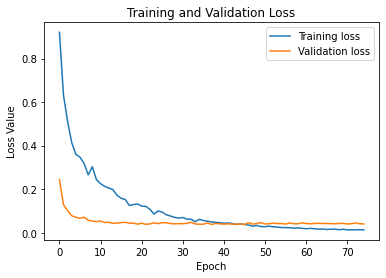

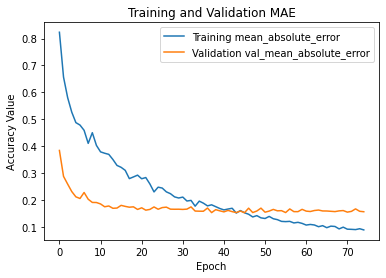

In [51]:
make_graphs(75,hist)

In [52]:
val_preds_dp = model.predict(val_x)
val_preds_dp = val_preds_dp*max_age
print(r2_score(val_y*max_age, val_preds_dp))
print(explained_variance_score(val_y*max_age, val_preds_dp))
print(mean_absolute_error(val_y*max_age, val_preds_dp))
print(mean_squared_error(val_y*max_age, val_preds_dp))

0.12801814827534974
0.15573337403279752
14.637815157572428
355.7134960994591


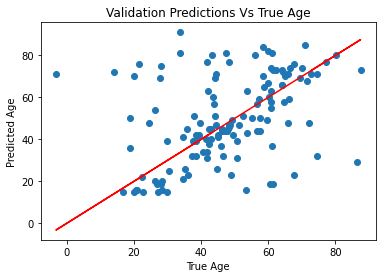

In [48]:
plt.scatter(val_preds_dp, val_y*max_age)
plt.plot(val_preds_dp, val_preds_dp, color = 'red', label = 'x=y')
plt.plot()
plt.title('Validation Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [47]:
test_preds_dp = model.predict(test_x)
test_preds_dp = test_preds_dp*max_age
print(r2_score(test_y*max_age, test_preds_dp))
print(explained_variance_score(test_y*max_age, test_preds_dp))
print(mean_absolute_error(test_y*max_age, test_preds_dp))
print(mean_squared_error(test_y*max_age, test_preds_dp))

0.6610695004343241
0.726894802311306
9.439860801174216
144.19626062925545


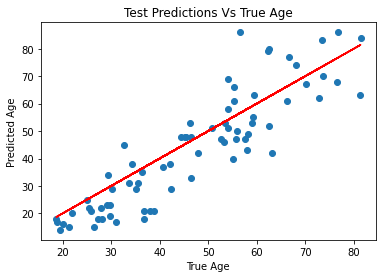

In [27]:
plt.scatter(test_preds_dp, test_y*max_age)
plt.plot(test_preds_dp, test_preds_dp, color = 'red', label = 'x=y')
plt.plot()
plt.title('Test Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [29]:
model.save("age_model1")

2021-12-07 21:16:54.434195: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: age_model1/assets


In [15]:
model.save("age_model1_log")

2021-12-02 04:35:10.803549: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: age_model1_log/assets


In [31]:
model = tf.keras.models.Sequential()
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='elu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50)

Epoch 1/50
17/17 [==============================] - 2s 32ms/step - loss: 0.5847 - mean_absolute_error: 0.6334 - val_loss: 0.2485 - val_mean_absolute_error: 0.4150
Epoch 2/50
17/17 [==============================] - 0s 13ms/step - loss: 0.4028 - mean_absolute_error: 0.5155 - val_loss: 0.1329 - val_mean_absolute_error: 0.2902
Epoch 3/50
17/17 [==============================] - 0s 15ms/step - loss: 0.3542 - mean_absolute_error: 0.4750 - val_loss: 0.1395 - val_mean_absolute_error: 0.3022
Epoch 4/50
17/17 [==============================] - 0s 13ms/step - loss: 0.3376 - mean_absolute_error: 0.4546 - val_loss: 0.1019 - val_mean_absolute_error: 0.2605
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 0.3038 - mean_absolute_error: 0.4358 - val_loss: 0.0587 - val_mean_absolute_error: 0.2007
Epoch 6/50
17/17 [==============================] - 0s 15ms/step - loss: 0.2497 - mean_absolute_error: 0.4007 - val_loss: 0.1009 - val_mean_absolute_error: 0.2576
Epoch 7/50
17/17 [====

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


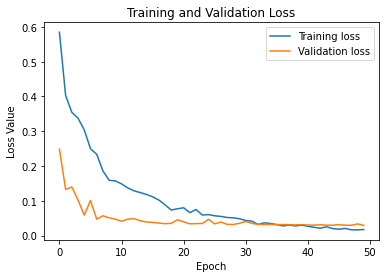

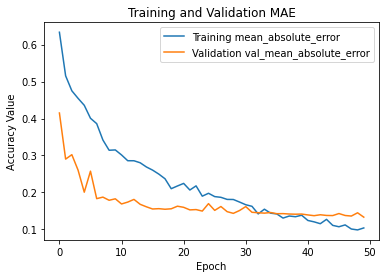

In [32]:
make_graphs(50,hist)

In [33]:
val_preds_dp = model.predict(val_x)
val_preds_dp = val_preds_dp*max_age
print(r2_score(val_y*max_age, val_preds_dp))
print(explained_variance_score(val_y*max_age, val_preds_dp))
print(mean_absolute_error(val_y*max_age, val_preds_dp))
print(mean_squared_error(val_y*max_age, val_preds_dp))

0.36444513048869753
0.36523762077211586
12.517470742716934
259.26622687130174


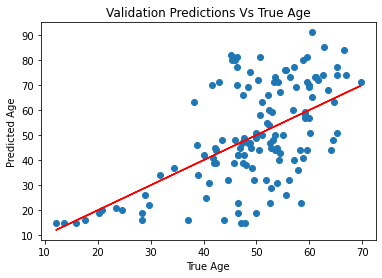

In [42]:
plt.scatter(val_preds_dp, val_y*max_age)
plt.plot(val_preds_dp, val_preds_dp, color = 'red', label = 'x=y')
plt.plot()
plt.title('Validation Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [35]:
test_preds_dp = model.predict(test_x)
test_preds_dp = test_preds_dp*max_age
print(r2_score(test_y*max_age, test_preds_dp))
print(explained_variance_score(test_y*max_age, test_preds_dp))
print(mean_absolute_error(test_y*max_age, test_preds_dp))
print(mean_squared_error(test_y*max_age, test_preds_dp))

0.5663103169450638
0.640608619625741
11.412646672497058
184.51107424721692


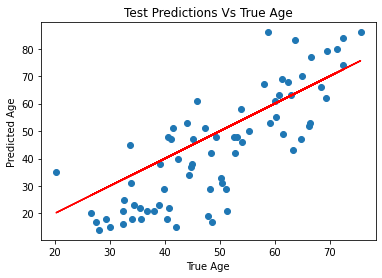

In [36]:
plt.scatter(test_preds_dp, test_y*max_age)
plt.plot(test_preds_dp, test_preds_dp, color = 'red', label = 'x=y')
plt.plot()
plt.title('Test Predictions Vs True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

In [37]:
model.save("smaller_age")

INFO:tensorflow:Assets written to: smaller_age/assets


In [41]:
pd.DataFrame(train_x).to_csv("model_train_x")
pd.DataFrame(train_y).to_csv("model_train_y")
pd.DataFrame(val_x).to_csv("model_val_x")
pd.DataFrame(val_y).to_csv("model_val_y")
pd.DataFrame(test_x).to_csv("model_test_x")
pd.DataFrame(test_y).to_csv("model_test_y")